# Lecture 3 - Discretisation of the Radon Transform

# Contents

* The discrete Radon transform
* Sparse matrices
* Matrix-free implementation
* Assignments

# The Discrete Radon Transform


The Radon transform is defined as 

$$f(\theta,s) = \int_{-\infty}^\infty u\left(x(s,t), y(s,t)\right) \mathrm{d}t,$$

with

$$x(s,t) = t \sin \theta + s \cos \theta, \quad y(s,t) = t\cos\theta - s \sin \theta.$$


* Let $s \in [-1,1]$ and discretise the detector in $n_d$ cells with width $2/n_d$.
* Let $(x,y) \in [-1,1]^2$ and discretise the image in $n_x \times n_y$ pixels with size $2/n_x \times 2/n_y$.
* The contribution of the $j-th$ pixel to the $i-th$ detector element at angle $\theta$ is then given by 

$$a_{ij}(\theta) = \int_{-\infty}^\infty \phi_j\left(x(s_i,t), y(s_i,t)\right) \mathrm{d}t,$$

with $\phi_j(x,y)$ is supported on the $j-th$ pixel.

* The measurement along a single angle then leads to a matrix $A(\theta) \in \mathbb{R}^{n_d \times n_x \dot n_y}$

We can now easily compute the matrix elements for a given set of angles $\{\theta_k\}_{k=1}^{n_\theta}$ and define

$$A = \left( \begin{matrix} A(\theta_1) \\ A(\theta_2) \\ \vdots \\ A(\theta_k)\end{matrix}\right).$$

The vectorised discretised sinogram and image are then related via

$$\mathbf{f} = A\mathbf{u}.$$

## The line model

* The weights $a_{ij}$ represent the length of the intersection between the $j-th$ ray and the $i-th$ pixel.
* We can compute these efficiently by solving for $t$ from
$$x = t \sin \theta + s \cos \theta, \quad y = t\cos\theta - s \sin \theta,$$
where $s$ is given and $x,y$ are the grid lines.
* This yields an array of intersection points $\{t_k\}_k$ along the ray and $t_{k} - t_{k-1}$ gives the intersection length
* Substituting $(t_{k} + t_{k-1})/2$ back in the line equation and rounding yields the central coordinates of the intersected pixels
* We can use these to compute the indices $i$ of the pixels that are intersected by the $j-th$ ray

In [43]:
import numpy as np

x = np.array([-1, -.5, 0, .5, 1])
y = np.array([-1, -.5, 0, .5, 1])
h = 0.5
s = np.array([-1.25, -.75, -.25, .25, .75, 1.25])

theta = 1
si = -.5

tx = (x - si*np.cos(theta)) / np.sin(theta)
ty = -(y - si*np.sin(theta)) / np.cos(theta)
t = np.sort(np.concatenate((tx,ty)))

xi = si*np.cos(theta) + t*np.sin(theta)
yi = si*np.sin(theta) - t*np.cos(theta)

xc = h*((si*np.cos(theta) + 0.5*(t[0:-1]+t[1:])*np.sin(theta))//h) + h/2
yc = h*((si*np.sin(theta) - 0.5*(t[0:-1]+t[1:])*np.cos(theta))//h) + h/2

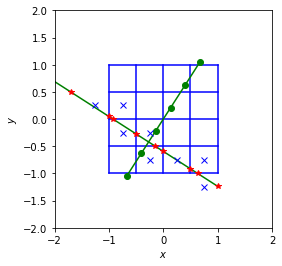

In [46]:
import matplotlib.pyplot as plt

ts = np.linspace(t[0],t[-1],100)
xx,yy = np.meshgrid(x,y)

fig, ax = plt.subplots()

ax.plot(xx,yy,'b')
ax.plot(yy,xx,'b')

ax.plot(si*np.cos(theta) + ts*np.sin(theta),si*np.sin(theta) - ts*np.cos(theta),'g')
ax.plot(s*np.cos(theta), s*np.sin(theta),'g-o')

ax.plot(xi,yi,'r*')
ax.plot(xc,yc,'bx')

ax.set_aspect(1)
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

plt.savefig('./figures/lecture3/linemodel.png',dpi=300)

![](./figures/lecture3/linemodel.png)

# Sparse matrices

* Let $n_x = n_y = n$ and $n_d = n_\theta = n$.
* We can easily see that we only have $\mathcal{O}(n)$ non-zeros in each row of the matrix; so $\mathcal{O}(n^3)$ non-zeros in total
* It is not very attractive to store and compute with all the zero-entries explicitly

## Sparse matrix formats

* `coo_array` Coordinate format
* `csc_array` Compressed Sparse Column format
* `csr_array` Compressed Sparse Row format

### COO

![](https://matteding.github.io/images/coo.gif)

### CSC

![](https://matteding.github.io/images/csc.gif)

### CSR

![](https://matteding.github.io/images/csr.gif)

# Matrix-free implementation

* For 3D applications, we'd end up with a matrix with $\mathcal{O}(n^4)$ non-zeros
* Using double precision, storage may take several Terabytes in practice ($n = 1000$).
* Can we instead compute the matrix elements on-the-fly?

* We can write a function to perform multiplication of $A$ by a given vector *implicitly*
* This avoids storage, but may induce some computational overhead
* We *cannot* access individual elements of the matrix easily
* We need to write a seperate function to multiply with the transpose of the matrix

## An example

Consider a finite-difference matrix

$$A = \left(\begin{matrix}-2 & 1& 0  & \ldots & \\ 1 & -2 & 1 & 0 \\ & \ddots & \ddots & \ddots & \\ 0 & \ldots &0 & 1 & -2 \end{matrix}\right).$$

The function would look like

```python 
def FD(u, n):
    v       = np.zeros(n)
    v[0]    = -2*u[0] + u[1]
    v[1:-1] = u[:-2] - 2*u[1:-1] + u[2:]
    v[-1]   = u[-2] - 2*u[-1]
    
```

## Another example

Consider summing the elements of a vector

$$A = (1, 1, 1, \ldots, 1).$$

```python
def sum(u,n):
    return np.sum(u)
```

```python
def sum_transpose(v,n):
    u = v * np.ones(n)
```

# Assignments

## Assignment 1

Write a function `RadonMatrix(n, s, theta)` that discretizes the Radon transform of a given `n` $\times$ `n` image, defined on $[-1,1]^2$, for given arrays `s` and `theta` and returns a matrix of size `len(s)*len(theta)` by `n*n`.

You can start with a loop that traces each ray individually and computes the weights in the matrix according to the procedure we outlined in class. If you are familiar with `numpy` you can attempt to make it more efficient.

## Assignment 2

Write a function `RadonSparseMatrix` which returns a sparse matrix representation of `RadonMatrix`.

* Check that it indeed gives the same ouput as `RadonMatrix`
* Do you notice a difference in computational time for dense and sparse matrices?
* Check the above for multiplication with the matrix and its tranpose for various sparse matrix formats

## Assignment 3

Write a function `Radon(u, n, s, theta)` which performs the Radon transform of the given image `u` and the corresponding transpose `RadonTranspose(f, n, s, theta)`.

* Check that they give the same result as multiplying by the matrix
* Check the computational time and memory requirements